# Phase space analysis

In this notebook, we analyze whether the phase-space structure explored in our analytic work manifests in the data. The first thing we are looking for is that the nullcline is the lower bound on temperature and moisture at all timescales. The next thing we're looking for is on seasonal timescales whether the points in temperature-moisture space all fall on the respective nullcline.

We will conduct this analysis by making phase space plots in numerous locations on the planet. Time to look up some locations. Tucson/Salt Lake/Denver will certainly be some of the locations. :) 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import glob 
import cartopy
import cartopy.crs as ccrs 

import sys
sys.path.append("/data/keeling/a/adammb4/heatwaves-physics/src/")
from getDataProcessing import *

In [2]:
def getLatLongIndex(lat, long, delta_lat=0.1, delta_long=0.1):
    index_lat = int( (90 - lat) * delta_lat**(-1) )
    index_long = int( long * delta_long**(-1) )
    
    return index_lat, index_long

In [3]:
era5_PATH = "/data/keeling/a/adammb4/heatwaves-physics/data/era5/"
model_params_name = glob.glob(era5_PATH + "model_params3.nc")
land_name = glob.glob(era5_PATH + "dewpt*")

model_params_ds = xr.open_dataset(model_params_name[0])
land_ds = xr.open_dataset(land_name[0])

In [4]:
model_params_ds

<xarray.Dataset>
Dimensions:  (lat: 1801, long: 3600)
Coordinates:
  * long     (long) float32 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat      (lat) float32 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    alpha    (lat, long) float64 ...
    nu_L     (lat, long) float64 ...
    gamma    (lat, long) float32 ...

In [5]:
land_ds

<xarray.Dataset>
Dimensions:    (latitude: 1801, longitude: 3600, time: 122)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 1981-06-01 1981-07-01 ... 2021-07-01
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    ssrd       (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-06 17:42:26 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [6]:
temp_n = land_ds["t2m"].values
volmois_n = land_ds["swvl1"].values
moisfrac_n = volmois_n / np.nanmax(volmois_n, axis=0)

lat = land_ds["latitude"].values
long = land_ds["longitude"].values

np.nanmax(moisfrac_n), np.nanmin(moisfrac_n), np.nanmean(moisfrac_n)

<ipython-input-6-215eb7f697c1>:3: RuntimeWarning: All-NaN slice encountered
  moisfrac_n = volmois_n / np.nanmax(volmois_n, axis=0)
<ipython-input-6-215eb7f697c1>:3: RuntimeWarning: invalid value encountered in true_divide
  moisfrac_n = volmois_n / np.nanmax(volmois_n, axis=0)


(1.0, 0.0, 0.78930753)

In [7]:
tucson_lat = 40 # N
tucson_long = -88 + 180 # E 

tucson_lat_index, tucson_long_index = getLatLongIndex(tucson_lat, tucson_long)
tucson_lat_index, tucson_long_index

(500, 920)

In [8]:
lat[tucson_lat_index], long[tucson_long_index]

(40.0, 92.0)

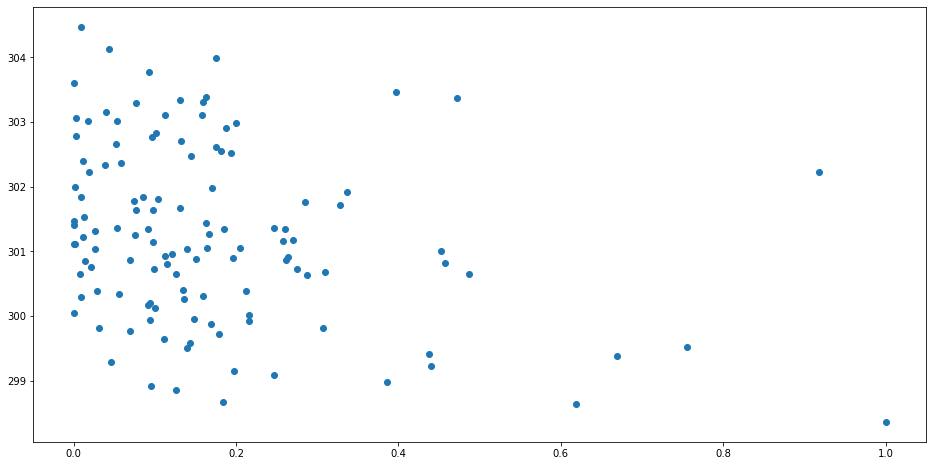

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

ax.scatter(moisfrac_n[:, tucson_lat_index, tucson_long_index], temp_n[:, tucson_lat_index, tucson_long_index])

Looks promising...

In [10]:
swflux_n = land_ds["ssrd"].values * 86400**(-1)
dewpt_n = land_ds["d2m"].values

In [11]:
alpha_n = model_params_ds['alpha'].values
nu_L_n = model_params_ds["nu_L"].values

In [12]:
P_surf = 101325 # Pa
L = 2.453e6 # J/kg
R_w = 461.52 #J/kg
T_0 = 273.15 # K

prefactor = 0.622 * L * (P_surf * R_w * dewpt_n**2)**(-1) * 6.11
exp_term = np.exp(L * R_w**(-1) * (T_0**(-1) - dewpt_n**(-1) ))

gamma_n= prefactor * exp_term

In [13]:
all_mois = np.linspace(0,1,10000)

In [14]:
time_index = 100

In [15]:
tucson_feedback = alpha_n[tucson_lat_index, tucson_long_index] + L * nu_L_n[tucson_lat_index, tucson_long_index] * gamma_n[time_index, tucson_lat_index, tucson_long_index] * all_mois
tucson_nullcline = swflux_n[time_index, tucson_lat_index, tucson_long_index] * (tucson_feedback)**(-1) + dewpt_n[time_index, tucson_lat_index, tucson_long_index]

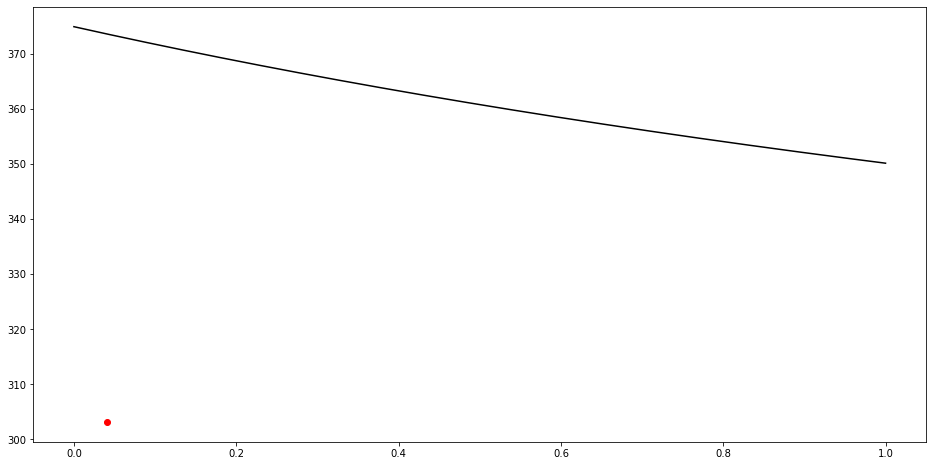

In [16]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(all_mois, tucson_nullcline, color='k')
ax.scatter(moisfrac_n[time_index, tucson_lat_index, tucson_long_index], temp_n[time_index, tucson_lat_index, tucson_long_index], color='r')